#State-Action Table

In this approach, each state is a combination of compiler flags, and actions are the application of a compiler flag.

State: Each possible combination of compiler flags.

Action: Applying a compiler flag.

Q-Table: The table will be a matrix where rows represent states (combinations of flags) and columns represent actions (possible next flags to add).

Action Representation:

Actions correspond to toggling each flag.

From state 000, actions are:

Toggle -O0: Resulting state 100

Toggle -O1: Resulting state 010

Toggle -O2: Resulting state 001

Episode 1/100, Rewards per episodes: -0.5500930000000002, Min Reward: -0.00808599999999999943800510493474575923755764961243 (State: (1, 0, 1, 1, 1, 1, 1, 0)), Max Reward: -0.00000099999999999999995474811182588625868561393872 (State: (0, 1, 0, 0, 1, 1, 0, 1)), Average Reward: -0.00550093
Episode 2/100, Rewards per episodes: -0.5783440000000001, Min Reward: -0.03392300000000000176347825231459864880889654159546 (State: (1, 0, 0, 0, 0, 0, 0, 0)), Max Reward: -0.00000099999999999999995474811182588625868561393872 (State: (0, 1, 1, 0, 0, 0, 0, 0)), Average Reward: -0.00578344
Episode 3/100, Rewards per episodes: -0.43261099999999914, Min Reward: -0.03453799999999999925659466271099518053233623504639 (State: (0, 0, 0, 0, 0, 0, 0, 0)), Max Reward: -0.00000099999999999999995474811182588625868561393872 (State: (0, 0, 0, 1, 0, 0, 0, 0)), Average Reward: -0.004326109999999999
Episode 4/100, Rewards per episodes: -0.21898900000000004, Min Reward: -0.03435400000000000259037236105541524011641740798950 

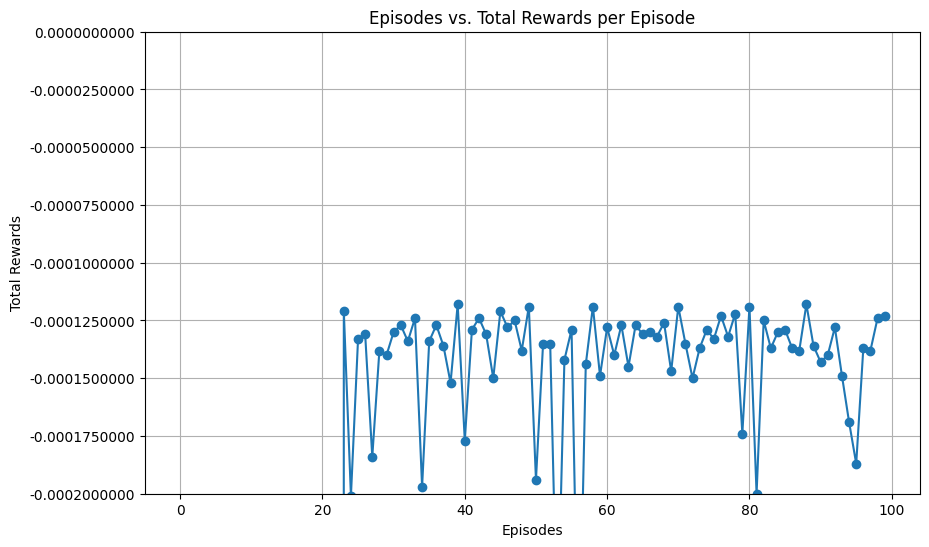

Episode 1/10, Total Reward: -0.00012199999999999978
Episode 2/10, Total Reward: -0.0001519999999999998
Episode 3/10, Total Reward: -0.00012499999999999979
Episode 4/10, Total Reward: -0.00014199999999999977
Episode 5/10, Total Reward: -0.0001199999999999998
Episode 6/10, Total Reward: -0.00013899999999999977
Episode 7/10, Total Reward: -0.0001479999999999998
Episode 8/10, Total Reward: -0.00013499999999999978
Episode 9/10, Total Reward: -0.00012399999999999982
Episode 10/10, Total Reward: -0.0001389999999999998
Active flags for each episode: [['-O3', '-fno-inline'], ['-O3', '-fno-inline'], ['-O3', '-fno-inline'], ['-O3', '-fno-inline'], ['-O3', '-fno-inline'], ['-O3', '-fno-inline'], ['-O3', '-fno-inline'], ['-O3', '-fno-inline'], ['-O3', '-fno-inline'], ['-O3', '-fno-inline']]
Inactive flags for each episode: [['-O0', '-O1', '-O2', '-Os', '-Ofast', '-Og'], ['-O0', '-O1', '-O2', '-Os', '-Ofast', '-Og'], ['-O0', '-O1', '-O2', '-Os', '-Ofast', '-Og'], ['-O0', '-O1', '-O2', '-Os', '-Ofast

In [ ]:
import numpy as np
import subprocess
import pickle
import os
import matplotlib.pyplot as plt
from itertools import product
from collections import deque

class StateActionCompilerEnv:
    def __init__(self, code_path):
        self.code_path = code_path
        self.flags = ['-O0', '-O1', '-O2', '-O3', '-Os', '-Ofast', '-Og', '-fno-inline']
        self.state_space = list(product([0, 1], repeat=len(self.flags)))
        self.action_space = len(self.flags)
        self.current_state = deque([0] * self.action_space)

    def reset(self):
        self.current_state = deque([0] * self.action_space)
        return tuple(self.current_state)

    def compile_and_measure(self, flags):
        flags_str = ' '.join([self.flags[i] for i, flag in enumerate(flags) if flag])
        compile_command = f"gcc {self.code_path} {flags_str} -o output"
        run_command = "./output"

        try:
            compile_result = subprocess.run(compile_command, shell=True, capture_output=True, text=True, timeout=10)
            if compile_result.returncode != 0:
                print("Compilation failed:", compile_result.stderr)
                return float('inf')

            subprocess.run(f"chmod +x output", shell=True)

            run_result = subprocess.run(run_command, shell=True, capture_output=True, text=True, timeout=10)
            if run_result.returncode != 0:
                print("Execution failed:", run_result.stderr)
                return float('inf')

            output_lines = run_result.stdout.strip().split('\n')
            execution_time = float(output_lines[-1])  # Assume the execution time is printed as the last line
            return execution_time

        except subprocess.TimeoutExpired:
            print("Execution timed out")
            return float('inf')

    def step(self, action):
        # Toggle the flag
        self.current_state[action] = 1 - self.current_state[action]
        execution_time = self.compile_and_measure(self.current_state)
        reward = -execution_time
        return tuple(self.current_state), reward, False

    def render(self):
        print(f"State: {list(self.current_state)}")

class StateActionQLearningAgent:
    def __init__(self, state_space, action_space, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0, exploration_decay=0.99,
                 q_table_file='q_table_State_Action_Table.pkl'):
        self.state_space = state_space
        self.action_space = action_space
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.epsilon_decay = exploration_decay
        self.q_table_file = q_table_file
        self.q_table = self.load_q_table()

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            state_actions = self.q_table.get(state, np.zeros(self.action_space))
            action = np.argmax(state_actions)
        return action

    def learn(self, state, action, reward, next_state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.action_space)
        if next_state not in self.q_table:
            self.q_table[next_state] = np.zeros(self.action_space)

        predict = self.q_table[state][action]
        target = reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state][action] += self.lr * (target - predict)
        self.epsilon *= self.epsilon_decay

    def save_q_table(self):
        with open(self.q_table_file, 'wb') as f:
            pickle.dump(self.q_table, f)
        print("Q-table saved.")

    def load_q_table(self):
        if os.path.exists(self.q_table_file):
            with open(self.q_table_file, 'rb') as f:
                print("Q-table loaded.")
                return pickle.load(f)
        else:
            return {}

def train_state_action(agent, env, episodes=100):
    rewards = []
    max_rewards = []
    mean_rewards = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        episode_rewards = []
        episode_states = []
        for step in range(100):
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.learn(state, action, reward, next_state)
            state = next_state
            total_reward += reward
            episode_rewards.append(reward)
            episode_states.append(state)
            if done:
                break

        rewards.append(total_reward)
        # Calculate min, max, and average reward
        min_reward = min(episode_rewards)
        max_reward = max(episode_rewards)
        avg_reward = np.mean(episode_rewards)

        # Find the states corresponding to min and max rewards
        min_state = episode_states[episode_rewards.index(min_reward)]
        max_state = episode_states[episode_rewards.index(max_reward)]

        print(f"Episode {episode + 1}/{episodes}, Rewards per episodes: {total_reward}, Min Reward: {min_reward:.50f} (State: {min_state}), Max Reward: {max_reward:.50f} (State: {max_state}), Average Reward: {avg_reward}")

    agent.save_q_table()
    plot_rewards(rewards, episodes)

def plot_rewards(rewards, episodes):
    print("rewards -- >", rewards)
    print("episodes -- >", episodes)
    plt.figure(figsize=(10, 6))
    plt.plot(range(episodes), rewards, marker='o', linestyle='-')
    plt.xlabel('Episodes')
    plt.ylabel('Total Rewards')
    plt.title('Episodes vs. Total Rewards per Episode')

    # Adjust y-axis to zoom into values closer to zero
    plt.ylim(-0.0002, 0)

    # Set y-ticks to show 10 decimal places
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.10f}'))

    plt.grid(True)
    plt.show()

def evaluate_state_action(agent, env, episodes=10):
    active_flags_list = []
    inactive_flags_list = []
    all_states_list = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        for step in range(100):
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            state = next_state
            total_reward += reward


            if done:
                break

        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")
        all_states_list.append(state)
        active_flags = [env.flags[i] for i, flag in enumerate(state) if flag]
        inactive_flags = [env.flags[i] for i, flag in enumerate(state) if not flag]
        active_flags_list.append(active_flags)
        inactive_flags_list.append(inactive_flags)

    return active_flags_list, inactive_flags_list, all_states_list

# Path to the new C file you want to test
new_code_path = 'sum.c'  # Change this to the path of your new code

# Initialize environment and agent with the new C file
env = StateActionCompilerEnv(new_code_path)
agent = StateActionQLearningAgent(env.state_space, env.action_space)

# Train the agent
train_state_action(agent, env)

# Evaluate the agent on the new C file and get the arrays of active, inactive flags and all states
active_flags, inactive_flags, all_states = evaluate_state_action(agent, env)
print("Active flags for each episode:", active_flags)
print("Inactive flags for each episode:", inactive_flags)
print("All states for each episode:", all_states)

# Interpret the active and inactive flags
for episode in range(len(all_states)):
    active_flags_str = ', '.join(active_flags[episode])
    inactive_flags_str = ', '.join(inactive_flags[episode])
    print(f"Episode {episode + 1}: Active flags - {active_flags_str}")
    print(f"Episode {episode + 1}: Inactive flags - {inactive_flags_str}")
    print(f"Episode {episode + 1}: All states - {all_states[episode]}")
    print("-----------------------------------------------------------")


In [ ]:
import pickle

def print_pickle_file(pickle_file_path):
    with open(pickle_file_path, 'rb') as f:
        data = pickle.load(f)
    print(data)

# Example usage
pickle_file_path = 'q_table_State_Action_Table.pkl'
print_pickle_file(pickle_file_path)

{(0, 0, 0, 0, 0, 0, 0, 0): array([-3.39230000e-03, -4.04900000e-04, -2.18148302e-06, -2.19520490e-06,
       -2.28588488e-06, -2.91511703e-06, -7.43300000e-04, -3.43540000e-03]), (0, 0, 0, 0, 0, 0, 1, 0): array([-0.00149269, -0.0007332 , -0.0007355 , -0.0007374 , -0.0007334 ,
       -0.0007813 , -0.00333764,  0.        ]), (0, 0, 0, 1, 0, 0, 1, 0): array([-7.397e-04, -7.306e-04, -7.711e-04, -7.356e-04, -7.447e-04,
       -7.302e-04, -1.000e-07,  0.000e+00]), (0, 0, 1, 1, 0, 0, 1, 0): array([-7.309e-04, -7.345e-04, -7.326e-04, -7.706e-04, -7.343e-04,
       -7.404e-04, -1.000e-07,  0.000e+00]), (0, 0, 1, 0, 0, 0, 1, 0): array([-7.395e-04, -7.431e-04, -7.353e-04, -7.543e-04, -7.329e-04,
       -7.487e-04, -3.090e-07,  0.000e+00]), (0, 0, 1, 0, 0, 1, 1, 0): array([-0.00140728, -0.0007355 , -0.0007354 , -0.0007278 , -0.0007459 ,
       -0.0007391 ,  0.        ,  0.        ]), (1, 0, 1, 0, 0, 1, 1, 0): array([-7.303e-04, -7.479e-04, -7.372e-04, -7.339e-04, -7.320e-04,
       -7.340e-04, -1.

In [ ]:
import pickle
import pandas as pd

# Load the pickle file
file_path = 'q_table_State_Action_Table.pkl'
with open(file_path, 'rb') as file:
    data = pickle.load(file)

# Method 1: Print the entire dictionary
print("Complete Dictionary:")
for key, value in data.items():
    print(f"Flags: {key}\nValues: {value}\n\n")
print("\n" + "="*50 + "\n")

Complete Dictionary:
Flags: (0, 0, 0, 0, 0, 0, 0, 0)
Values: [-3.39230000e-03 -4.04900000e-04 -2.18148302e-06 -2.19520490e-06
 -2.28588488e-06 -2.91511703e-06 -7.43300000e-04 -3.43540000e-03]


Flags: (0, 0, 0, 0, 0, 0, 1, 0)
Values: [-0.00149269 -0.0007332  -0.0007355  -0.0007374  -0.0007334  -0.0007813
 -0.00333764  0.        ]


Flags: (0, 0, 0, 1, 0, 0, 1, 0)
Values: [-7.397e-04 -7.306e-04 -7.711e-04 -7.356e-04 -7.447e-04 -7.302e-04
 -1.000e-07  0.000e+00]


Flags: (0, 0, 1, 1, 0, 0, 1, 0)
Values: [-7.309e-04 -7.345e-04 -7.326e-04 -7.706e-04 -7.343e-04 -7.404e-04
 -1.000e-07  0.000e+00]


Flags: (0, 0, 1, 0, 0, 0, 1, 0)
Values: [-7.395e-04 -7.431e-04 -7.353e-04 -7.543e-04 -7.329e-04 -7.487e-04
 -3.090e-07  0.000e+00]


Flags: (0, 0, 1, 0, 0, 1, 1, 0)
Values: [-0.00140728 -0.0007355  -0.0007354  -0.0007278  -0.0007459  -0.0007391
  0.          0.        ]


Flags: (1, 0, 1, 0, 0, 1, 1, 0)
Values: [-7.303e-04 -7.479e-04 -7.372e-04 -7.339e-04 -7.320e-04 -7.340e-04
 -1.000e-07  0.000e+

# Flag-Specific State-Action Table
Flag-Specific is simpler, focusing on active combinations.

**State:** The current set of flags applied (active flags).

**Action:** Adding one of the remaining inactive flags.

Flag-Specific State-Action Table:

State: Current set of active flags.

Action: Add remaining flags.

Example: Transition [] to ['-O0'].

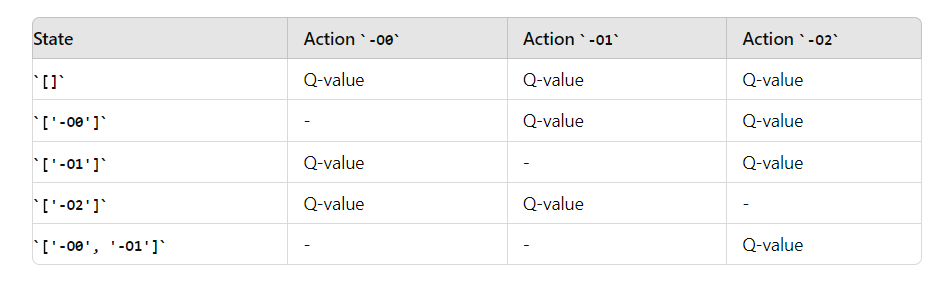

Q-table loaded.
Episode 1/100, Rewards per episodes: -0.928227, Min Reward: -0.03442900000000000126920696175147895701229572296143 (State: ('-fno-inline', '-O3', '-O1', '-O2', '-Og', '-Ofast', '-O0')), Max Reward: -0.00000099999999999999995474811182588625868561393872 (State: ('-Os', '-O2')), Average Reward: -0.00928227
Episode 2/100, Rewards per episodes: -0.9280479999999999, Min Reward: -0.03495800000000000296029867286051739938557147979736 (State: ('-O3', '-Ofast', '-O1', '-fno-inline', '-O0')), Max Reward: -0.00000099999999999999995474811182588625868561393872 (State: ('-O2', '-O0', '-O1', '-Os')), Average Reward: -0.00928048
Episode 3/100, Rewards per episodes: -0.7537509999999997, Min Reward: -0.03486199999999999715738496774974919389933347702026 (State: ('-O2', '-Os', '-O3', '-fno-inline', '-Ofast', '-O1', '-O0')), Max Reward: -0.00000099999999999999995474811182588625868561393872 (State: ('-Ofast',)), Average Reward: -0.007537510000000001
Episode 4/100, Rewards per episodes: -0.64622

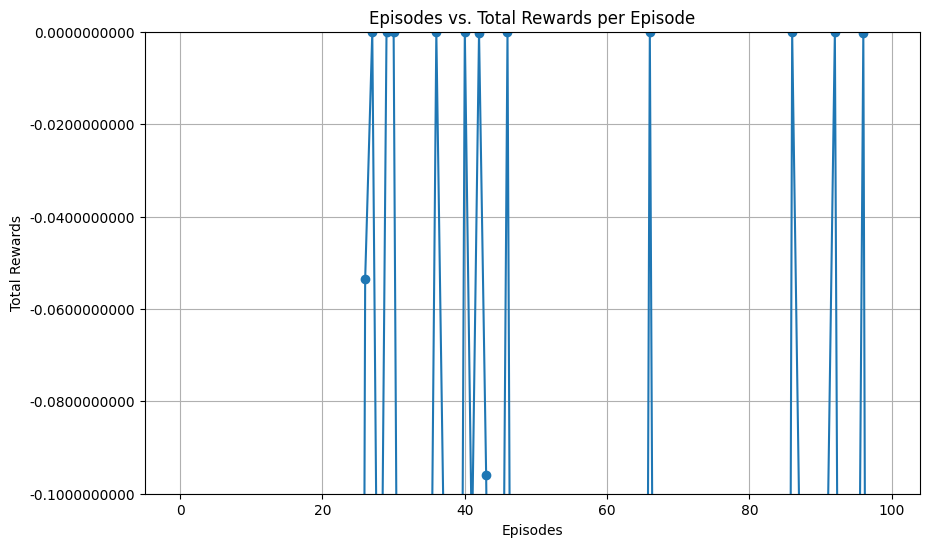

Episode 1/10, Total Reward: -0.0001309999999999998
Episode 2/10, Total Reward: -0.0001569999999999998
Episode 3/10, Total Reward: -0.0001339999999999998
Episode 4/10, Total Reward: -0.0001209999999999998
Episode 5/10, Total Reward: -0.00012999999999999977
Episode 6/10, Total Reward: -0.0001289999999999998
Episode 7/10, Total Reward: -0.0001339999999999998
Episode 8/10, Total Reward: -0.0001199999999999998
Episode 9/10, Total Reward: -0.00013099999999999982
Episode 10/10, Total Reward: -0.0001279999999999998
Active flags for each episode: [['-O3', '-O2', '-fno-inline', '-Os'], ['-O3', '-O2', '-fno-inline', '-Os'], ['-O3', '-O2', '-fno-inline', '-Os'], ['-O3', '-O2', '-fno-inline', '-Os'], ['-O3', '-O2', '-fno-inline', '-Os'], ['-O3', '-O2', '-fno-inline', '-Os'], ['-O3', '-O2', '-fno-inline', '-Os'], ['-O3', '-O2', '-fno-inline', '-Os'], ['-O3', '-O2', '-fno-inline', '-Os'], ['-O3', '-O2', '-fno-inline', '-Os']]
Inactive flags for each episode: [['-O0', '-O1', '-Ofast', '-Og'], ['-O0', 

In [ ]:
import numpy as np
import subprocess
import pickle
import os
import matplotlib.pyplot as plt
from collections import deque

class FlagSpecificCompilerEnv:
    def __init__(self, code_path):
        self.code_path = code_path
        self.flags = ['-O0', '-O1', '-O2', '-O3', '-Os', '-Ofast', '-Og', '-fno-inline']
        self.state_space = len(self.flags)
        self.action_space = len(self.flags)
        self.current_state = deque()

    def reset(self):
        self.current_state.clear()
        return tuple(self.current_state)

    def compile_and_measure(self, flags):
        flags_str = ' '.join(flags)
        compile_command = f"gcc {self.code_path} {flags_str} -o output"
        run_command = "./output"

        try:
            compile_result = subprocess.run(compile_command, shell=True, capture_output=True, text=True, timeout=10)
            if compile_result.returncode != 0:
                print("Compilation failed:", compile_result.stderr)
                return float('inf')

            subprocess.run(f"chmod +x output", shell=True)

            run_result = subprocess.run(run_command, shell=True, capture_output=True, text=True, timeout=10)
            if run_result.returncode != 0:
                print("Execution failed:", run_result.stderr)
                return float('inf')

            output_lines = run_result.stdout.strip().split('\n')
            execution_time = float(output_lines[-1])
            return execution_time

        except subprocess.TimeoutExpired:
            print("Execution timed out")
            return float('inf')

    def step(self, action):
        flag = self.flags[action]
        if flag in self.current_state:
            self.current_state.remove(flag)
        else:
            self.current_state.append(flag)

        execution_time = self.compile_and_measure(list(self.current_state))
        reward = -execution_time
        return tuple(self.current_state), reward, False

    def render(self):
        print(f"State: {list(self.current_state)}")

class FlagSpecificQLearningAgent:
    def __init__(self, state_space, action_space, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0, exploration_decay=0.99,
                 q_table_file='q_table_Flag_Specific_State_Action_Table.pkl'):
        self.state_space = state_space
        self.action_space = action_space
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.epsilon_decay = exploration_decay
        self.q_table_file = q_table_file
        self.q_table = self.load_q_table()

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            state_actions = self.q_table.get(state, np.zeros(self.action_space))
            action = np.argmax(state_actions)
        return action

    def learn(self, state, action, reward, next_state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.action_space)
        if next_state not in self.q_table:
            self.q_table[next_state] = np.zeros(self.action_space)

        predict = self.q_table[state][action]
        target = reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state][action] += self.lr * (target - predict)
        self.epsilon *= self.epsilon_decay

    def save_q_table(self):
        with open(self.q_table_file, 'wb') as f:
            pickle.dump(self.q_table, f)
        print("Q-table saved.")

    def load_q_table(self):
        if os.path.exists(self.q_table_file):
            with open(self.q_table_file, 'rb') as f:
                print("Q-table loaded.")
                return pickle.load(f)
        else:
            return {}

def train_flag_specific(agent, env, episodes=100):
    rewards = []
    max_rewards = []
    mean_rewards = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        episode_rewards = []
        episode_states = []
        for step in range(100):
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.learn(state, action, reward, next_state)
            state = next_state
            total_reward += reward
            episode_rewards.append(reward)
            episode_states.append(state)
            if done:
                break

        rewards.append(total_reward)
        # Calculate min, max, and average reward
        min_reward = min(episode_rewards)
        max_reward = max(episode_rewards)
        avg_reward = np.mean(episode_rewards)

        # Find the states corresponding to min and max rewards
        min_state = episode_states[episode_rewards.index(min_reward)]
        max_state = episode_states[episode_rewards.index(max_reward)]

        print(f"Episode {episode + 1}/{episodes}, Rewards per episodes: {total_reward}, Min Reward: {min_reward:.50f} (State: {min_state}), Max Reward: {max_reward:.50f} (State: {max_state}), Average Reward: {avg_reward}")

    agent.save_q_table()
    plot_rewards(rewards, episodes)

def plot_rewards(rewards, episodes):
    print("rewards -- >", rewards)
    print("episodes -- >", episodes)
    plt.figure(figsize=(10, 6))
    plt.plot(range(episodes), rewards, marker='o', linestyle='-')
    plt.xlabel('Episodes')
    plt.ylabel('Total Rewards')
    plt.title('Episodes vs. Total Rewards per Episode')

    # Adjust y-axis to zoom into values closer to zero
    plt.ylim(-0.1, 0)

    # Set y-ticks to show 10 decimal places
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.10f}'))

    plt.grid(True)
    plt.show()

def evaluate_flag_specific(agent, env, episodes=10):
    active_flags_list = []
    inactive_flags_list = []
    all_states_list = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        for step in range(100):
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            state = next_state
            total_reward += reward

            if done:
                break

        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")
        all_states_list.append(state)
        active_flags = list(state)
        inactive_flags = [flag for flag in env.flags if flag not in state]
        active_flags_list.append(active_flags)
        inactive_flags_list.append(inactive_flags)

    return active_flags_list, inactive_flags_list, all_states_list

# Path to the new C file you want to test
new_code_path = 'sum.c'  # Change this to the path of your new code

# Initialize environment and agent with the new C file
env = FlagSpecificCompilerEnv(new_code_path)
agent = FlagSpecificQLearningAgent(env.state_space, env.action_space)

# Train the agent
train_flag_specific(agent, env)

# Evaluate the agent on the new C file and get the arrays of active, inactive flags and all states
active_flags, inactive_flags, all_states = evaluate_flag_specific(agent, env)
print("Active flags for each episode:", active_flags)
print("Inactive flags for each episode:", inactive_flags)
print("All states for each episode:", all_states)

# Interpret the active and inactive flags
for episode in range(len(all_states)):
    active_flags_str = ', '.join(active_flags[episode])
    inactive_flags_str = ', '.join(inactive_flags[episode])
    print(f"Episode {episode + 1}: Active flags - {active_flags_str}")
    print(f"Episode {episode + 1}: Inactive flags - {inactive_flags_str}")
    print(f"Episode {episode + 1}: All states - {all_states[episode]}")
    print("-----------------------------------------------------------")


In [ ]:
import pickle

def print_pickle_file(pickle_file_path):
    with open(pickle_file_path, 'rb') as f:
        data = pickle.load(f)
    print(data)

# Example usage
pickle_file_path = 'q_table_Flag_Specific_State_Action_Table.pkl'
print_pickle_file(pickle_file_path)

{(): array([-3.36750000e-03, -1.16376000e-03, -2.19571030e-06, -2.98974898e-06,
       -2.18566721e-06, -2.22843060e-06, -7.31700000e-04, -3.35930000e-03]), ('-O0',): array([ 0.e+00,  0.e+00,  0.e+00, -2.e-07,  0.e+00,  0.e+00,  0.e+00,
        0.e+00]), ('-O0', '-O3'): array([-1.000e-07,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00, -7.327e-04,  0.000e+00]), ('-O0', '-O3', '-Og'): array([ 0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00, -1.e-07,
        0.e+00]), ('-O3',): array([-3.49200000e-03, -3.98200000e-04, -1.67766157e-06, -3.37450000e-03,
       -1.65604534e-06, -1.70506920e-06, -7.34000000e-04, -1.65725957e-06]), ('-O3', '-Ofast'): array([-3.33030000e-03, -3.93300000e-04, -1.16083360e-06, -1.09882454e-06,
       -1.06110926e-06, -1.12085473e-06, -8.24100000e-04, -1.17547484e-06]), ('-O3', '-Ofast', '-O0'): array([ 0.       ,  0.       ,  0.       , -0.0033178,  0.       ,
        0.       ,  0.       ,  0.       ]), ('-Ofast', '-O0'): array([-1.000e-0

In [ ]:
import pickle
import pandas as pd

# Load the pickle file
file_path = 'q_table_Flag_Specific_State_Action_Table.pkl'
with open(file_path, 'rb') as file:
    data = pickle.load(file)

# Method 1: Print the entire dictionary
print("Complete Dictionary:")
for key, value in data.items():
    print(f"Flags: {key}\nValues: {value}\n\n")
print("\n" + "="*50 + "\n")

Streaming output truncated to the last 5000 lines.
Values: [-3.4167e-03 -1.0000e-07  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00]


Flags: ('-fno-inline', '-Og', '-O2', '-Ofast', '-O1', '-O0')
Values: [-0.0003984  0.         0.         0.         0.         0.
  0.         0.       ]


Flags: ('-O2', '-O3', '-Ofast', '-Os')
Values: [-2.6945e-03 -8.3610e-04 -2.0981e-07 -2.3168e-07  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00]


Flags: ('-O2', '-O3', '-Ofast', '-Os', '-O0')
Values: [-1.e-07  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00]


Flags: ('-O2', '-O3', '-Ofast', '-Os', '-O1')
Values: [-2.649e-03 -1.000e-07  0.000e+00  0.000e+00  0.000e+00  0.000e+00
  0.000e+00  0.000e+00]


Flags: ('-O2', '-O3', '-Ofast', '-Os', '-O1', '-O0')
Values: [-0.0007725  0.         0.         0.         0.         0.
  0.         0.       ]


Flags: ('-O2', '-fno-inline', '-Ofast', '-Os')
Values: [-2.71390000e-03 -8.11200000e-04 -1.22855311e-07 -1.00000000e-07
 

# Sequential Action State-Action Table

Q-table loaded.
Episode 1/100, Rewards per episodes: -0.8289629999999996, Min Reward: -0.03484799999999999703392816741143178660422563552856 (State: ('-Os', '-O2', '-Ofast', '-O3', '-O1', '-O0')), Max Reward: -0.00000099999999999999995474811182588625868561393872 (State: ('-Og', '-Ofast')), Average Reward: -0.00828963
Episode 2/100, Rewards per episodes: -0.8400500000000001, Min Reward: -0.03451200000000000100985886319904238916933536529541 (State: ('-Os', '-Ofast', '-O3', '-O1', '-O0')), Max Reward: -0.00000099999999999999995474811182588625868561393872 (State: ('-Og', '-O3', '-O1', '-O2')), Average Reward: -0.0084005
Episode 3/100, Rewards per episodes: -0.5665439999999997, Min Reward: -0.03515499999999999874988887427207373548299074172974 (State: ('-Os', '-O3', '-fno-inline', '-O1', '-O2', '-O0')), Max Reward: -0.00000099999999999999995474811182588625868561393872 (State: ('-O2',)), Average Reward: -0.005665440000000001
Episode 4/100, Rewards per episodes: -0.5560749999999994, Min Reward:

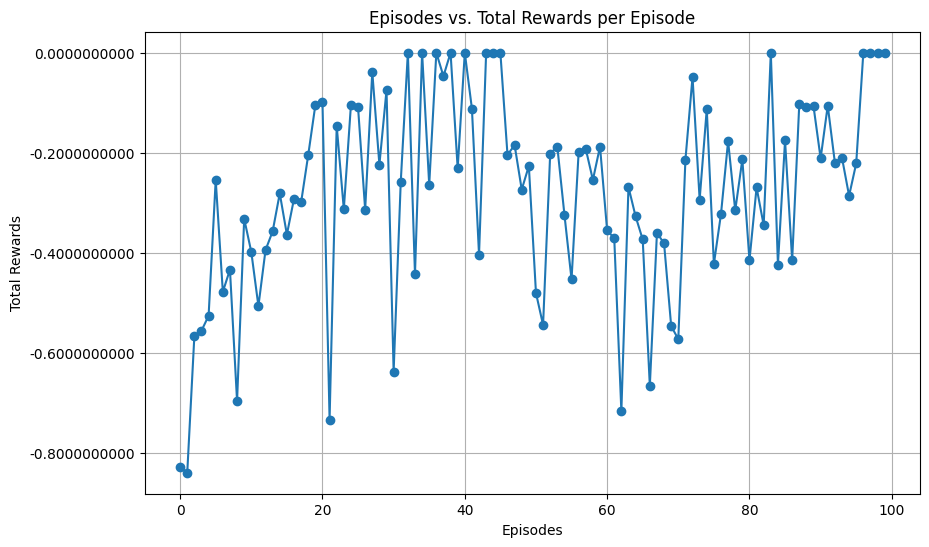

Episode 1/10, Total Reward: -0.00011599999999999981
Episode 2/10, Total Reward: -0.0001399999999999998
Episode 3/10, Total Reward: -0.00012599999999999978
Episode 4/10, Total Reward: -0.00013599999999999978
Episode 5/10, Total Reward: -0.0001249999999999998
Episode 6/10, Total Reward: -0.00014399999999999976
Episode 7/10, Total Reward: -0.0001189999999999998
Episode 8/10, Total Reward: -0.0001299999999999998
Episode 9/10, Total Reward: -0.0001789999999999998
Episode 10/10, Total Reward: -0.0001409999999999998
Active flags for each episode: [['-Os', '-Ofast', '-O3', '-O2'], ['-Os', '-Ofast', '-O3', '-O2'], ['-Os', '-Ofast', '-O3', '-O2'], ['-Os', '-Ofast', '-O3', '-O2'], ['-Os', '-Ofast', '-O3', '-O2'], ['-Os', '-Ofast', '-O3', '-O2'], ['-Os', '-Ofast', '-O3', '-O2'], ['-Os', '-Ofast', '-O3', '-O2'], ['-Os', '-Ofast', '-O3', '-O2'], ['-Os', '-Ofast', '-O3', '-O2']]
Inactive flags for each episode: [['-O0', '-O1', '-Og', '-fno-inline'], ['-O0', '-O1', '-Og', '-fno-inline'], ['-O0', '-O1'

In [ ]:
import numpy as np
import subprocess
import pickle
import os
import matplotlib.pyplot as plt
from collections import deque

class SequentialActionCompilerEnv:
    def __init__(self, code_path):
        self.code_path = code_path
        self.flags = ['-O0', '-O1', '-O2', '-O3', '-Os', '-Ofast', '-Og', '-fno-inline']
        self.state_space = len(self.flags)
        self.action_space = len(self.flags)
        self.current_state = deque()

    def reset(self):
        self.current_state.clear()
        return tuple(self.current_state)

    def compile_and_measure(self, flags):
        flags_str = ' '.join(flags)
        compile_command = f"gcc {self.code_path} {flags_str} -o output"
        run_command = "./output"

        try:
            compile_result = subprocess.run(compile_command, shell=True, capture_output=True, text=True, timeout=10)
            if compile_result.returncode != 0:
                print("Compilation failed:", compile_result.stderr)
                return float('inf')

            subprocess.run(f"chmod +x output", shell=True)

            run_result = subprocess.run(run_command, shell=True, capture_output=True, text=True, timeout=10)
            if run_result.returncode != 0:
                print("Execution failed:", run_result.stderr)
                return float('inf')

            output_lines = run_result.stdout.strip().split('\n')
            execution_time = float(output_lines[-1])
            return execution_time

        except subprocess.TimeoutExpired:
            print("Execution timed out")
            return float('inf')

    def step(self, action):
        flag = self.flags[action]
        if flag in self.current_state:
            self.current_state.remove(flag)
        else:
            self.current_state.append(flag)

        execution_time = self.compile_and_measure(list(self.current_state))
        reward = -execution_time
        return tuple(self.current_state), reward, False

    def render(self):
        print(f"State: {list(self.current_state)}")

class SequentialActionQLearningAgent:
    def __init__(self, state_space, action_space, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0, exploration_decay=0.99,
                 q_table_file='Sequential_Action_State_Action_Table.pkl'):
        self.state_space = state_space
        self.action_space = action_space
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.epsilon_decay = exploration_decay
        self.q_table_file = q_table_file
        self.q_table = self.load_q_table()

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            state_actions = self.q_table.get(state, np.zeros(self.action_space))
            action = np.argmax(state_actions)
        return action

    def learn(self, state, action, reward, next_state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.action_space)
        if next_state not in self.q_table:
            self.q_table[next_state] = np.zeros(self.action_space)

        predict = self.q_table[state][action]
        target = reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state][action] += self.lr * (target - predict)
        self.epsilon *= self.epsilon_decay

    def save_q_table(self):
        with open(self.q_table_file, 'wb') as f:
            pickle.dump(self.q_table, f)
        print("Q-table saved.")

    def load_q_table(self):
        if os.path.exists(self.q_table_file):
            with open(self.q_table_file, 'rb') as f:
                print("Q-table loaded.")
                return pickle.load(f)
        else:
            return {}

def train_sequential_action(agent, env, episodes=100):
    rewards = []
    max_rewards = []
    mean_rewards = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        episode_rewards = []
        episode_states = []
        for step in range(100):
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.learn(state, action, reward, next_state)
            state = next_state
            total_reward += reward
            episode_rewards.append(reward)
            episode_states.append(state)
            if done:
                break

        rewards.append(total_reward)
        # Calculate min, max, and average reward
        min_reward = min(episode_rewards)
        max_reward = max(episode_rewards)
        avg_reward = np.mean(episode_rewards)

        # Find the states corresponding to min and max rewards
        min_state = episode_states[episode_rewards.index(min_reward)]
        max_state = episode_states[episode_rewards.index(max_reward)]

        print(f"Episode {episode + 1}/{episodes}, Rewards per episodes: {total_reward}, Min Reward: {min_reward:.50f} (State: {min_state}), Max Reward: {max_reward:.50f} (State: {max_state}), Average Reward: {avg_reward}")

    agent.save_q_table()
    plot_rewards(rewards, episodes)

def plot_rewards(rewards, episodes):
    print("rewards -- >", rewards)
    print("episodes -- >", episodes)
    plt.figure(figsize=(10, 6))
    plt.plot(range(episodes), rewards, marker='o', linestyle='-')
    plt.xlabel('Episodes')
    plt.ylabel('Total Rewards')
    plt.title('Episodes vs. Total Rewards per Episode')

    # Adjust y-axis to zoom into values closer to zero
    #plt.ylim(-0.002, 0)

    # Set y-ticks to show 10 decimal places
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.10f}'))

    plt.grid(True)
    plt.show()

def evaluate_sequential_action(agent, env, episodes=10):
    active_flags_list = []
    inactive_flags_list = []
    all_states_list = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        for step in range(100):
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            state = next_state
            total_reward += reward

            if done:
                break

        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")
        all_states_list.append(state)
        active_flags = list(state)
        inactive_flags = [flag for flag in env.flags if flag not in state]
        active_flags_list.append(active_flags)
        inactive_flags_list.append(inactive_flags)

    return active_flags_list, inactive_flags_list, all_states_list

# Path to the new C file you want to test
new_code_path = 'sum.c'  # Change this to the path of your new code

# Initialize environment and agent with the new C file
env = SequentialActionCompilerEnv(new_code_path)
agent = SequentialActionQLearningAgent(env.state_space, env.action_space)

# Train the agent
train_sequential_action(agent, env)

# Evaluate the agent on the new C file and get the arrays of active, inactive flags and all states
active_flags, inactive_flags, all_states = evaluate_sequential_action(agent, env)
print("Active flags for each episode:", active_flags)
print("Inactive flags for each episode:", inactive_flags)
print("All states for each episode:", all_states)

# Interpret the active and inactive flags
for episode in range(len(all_states)):
    active_flags_str = ', '.join(active_flags[episode])
    inactive_flags_str = ', '.join(inactive_flags[episode])
    print(f"Episode {episode + 1}: Active flags - {active_flags_str}")
    print(f"Episode {episode + 1}: Inactive flags - {inactive_flags_str}")
    print(f"Episode {episode + 1}: All states - {all_states[episode]}")
    print("-----------------------------------------------------------")
